This notebook uses a convolution to deduce the orbital period from count rate data

In [13]:
from astropy.table import Table
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
from astropy.io import ascii
import matplotlib.pyplot as plt
import datetime
import numbers

R = 6378
H = 419
G = 6.673e-11
M = 5.972e24
theta = np.arcsin(R/(R+H))

tabEVT = Table.read('cleanfilt.evt', hdu=1)
eventTime = np.array(tabEVT['TIME'])
enArray = np.array(tabEVT['PI'])

startMKF = 2264
stopMKF = 2374

# read in the data files
tabMKF = Table.read('ni2200300102.mkf', hdu=1)
timeMKF = np.array(tabMKF['TIME'])
elevMKF = np.array(tabMKF['ELV'])

def Interpolator(col_mkf):
    f = interpolate.interp1d(timeMKF, col_mkf, kind='linear')
    return f(eventTime)

elev_evt = Interpolator(elevMKF)

In [15]:
def countRate(timeArray):
    binnedElev = []
    binCounts = []
    binTime = []
    timeList = []
    for i in np.arange(min(timeArray), max(timeArray)+1, 1):
        desind = np.where((timeArray >= i) & (timeArray < i + 1))
        if(len(desind[0]) != 0):
            binnedElev.append(np.mean(elev_evt[desind[0]]))
            binCounts.append(np.size(desind[0]))
            binTime.append(np.mean(timeArray[desind[0]]))
        else:
            binnedElev.append(None)
            binCounts.append(0)
            binTime.append(i)
    return np.array(binCounts), np.array(binTime), np.array(binnedElev)
    
rate, binnedTime, binnedElev = countRate(eventTime)

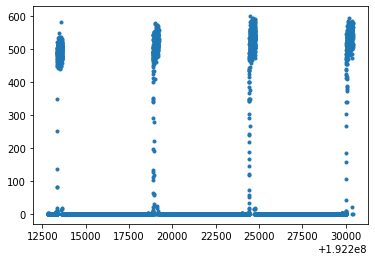

In [5]:
plt.plot(binnedTime,rate, '.')

In [4]:
from numpy.fft import fft, ifft, fftfreq
freqs = fftfreq(len(rate))
fft_vals = fft(rate)

(-0.01, 0.01)

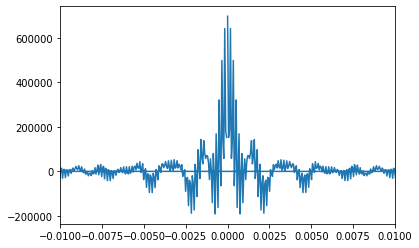

In [5]:
plt.plot(freqs,fft_vals.real)
plt.xlim(-0.01,0.01)

In [6]:
from numpy import convolve
half = int(len(rate)/2)
convolution = convolve(rate[0:half],rate[half-1:len(rate)])

Text(0.5, 0, 'Seconds')

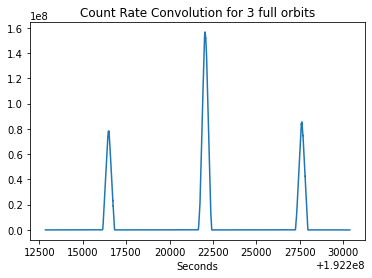

In [7]:
%matplotlib inline
plt.title("Count Rate Convolution for 3 full orbits")
plt.plot(binnedTime, convolution)
plt.xlabel("Seconds")

In [8]:
# This method requires that you know how many orbits you've done, aka you know how many peaks are in the graph
numOrbits = 3
timeList = []
for i in range(0,numOrbits):
    a = np.where(convolution==np.max(convolution[int(i*len(convolution)/numOrbits):int((i+1)*len(convolution)/numOrbits)]))
    timeList.append(binnedTime[a[0][0]])
    
# The best estimate:   
convolvedPeriod = (timeList[numOrbits-1]-timeList[0])/(numOrbits-1)
print(convolvedPeriod)

5566.5


In [9]:
# This is one peak finding function that works, but you have to be pretty careful with the second argument (CWT matrix)
from scipy.signal import find_peaks_cwt
peaks = find_peaks_cwt(convolution,np.arange(400,600)) #2nd arg is estimated width of peak (exposure time)
print((peaks[2]-peaks[0])/2)
# This is actually 3 seconds better

5569.5


In [10]:
omegaCalc = (2*np.pi)/convolvedPeriod
omegaCalc

0.0011287497183471815

In [11]:
periodExp = np.sqrt(4*np.pi**2*(((R+H)*1000)**3/(G*M)))
periodExp

5577.445192047022

In [12]:
omegaExp = 2*np.pi/periodExp
omegaExp

0.0011265346571471275

In [13]:
# read in MKF file
startMKF = 2264 - 18 #we usually have this at -15 because the evt in missing some data earlier
stopMKF = 2374 + 184

# read in the data files
tabMKF = Table.read('ni2200300102.mkf', hdu=1)
timeMKF = np.array(tabMKF['TIME'][startMKF:stopMKF])
elevMKF = np.array(tabMKF['ELV'][startMKF:stopMKF])

In [14]:
epsilonSlope=(elevMKF[len(elevMKF)-1]-elevMKF[0])/(timeMKF[len(timeMKF)-1]-timeMKF[0])

In [15]:
periodCalcSlope = 2*np.pi/np.deg2rad(epsilonSlope)
periodCalcSlope

5585.067657211581

In [16]:
%matplotlib
plt.plot(binnedTime, rate, '.')
plt.plot(binnedTime, binnedElev)

Using matplotlib backend: MacOSX
